In [57]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load CSV
df = pd.read_csv("dataset.csv")

In [58]:
df = df.drop(columns=["zipcodeOri", "zipMerchant"])

# Remove single quotes from all object (string) columns
df = df.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Replace 'U' in age with -1, then convert age to numeric
df['age'] = df['age'].replace('U', -1)
df['age'] = pd.to_numeric(df['age'], errors='coerce')  # Converts all to numeric, NaN if invalid

In [59]:
# Sort the DataFrame based on 'step'
df = df.sort_values(by='step')

df

,step,customer,age,gender,merchant,category,amount,fraud
425126,0,C182918114,5,F,M1535107174,es_wellnessandbeauty,128.26,0
168550,0,C1413774656,2,F,M692898500,es_health,15.04,0
372208,0,C2116616608,4,F,M348934600,es_transportation,34.73,0
36658,0,C976209265,4,M,M348934600,es_transportation,34.66,0
471754,0,C260840933,2,M,M348934600,es_transportation,25.59,0
...,...,...,...,...,...,...,...,...
330628,179,C1978250683,3,F,M1053599405,es_health,35.55,0
535142,179,C358037591,3,M,M1823072687,es_transportation,37.62,0
56,179,C1313060996,3,F,M1823072687,es_transportation,29.06,0
49785,179,C409331076,4,M,M1823072687,es_transportation,17.78,0


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 535178 entries, 425126 to 49743
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   step      535178 non-null  int64  
 1   customer  535178 non-null  object 
 2   age       535178 non-null  int64  
 3   gender    535178 non-null  object 
 4   merchant  535178 non-null  object 
 5   category  535178 non-null  object 
 6   amount    535178 non-null  float64
 7   fraud     535178 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 36.7+ MB


In [61]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# =========================
# 1. TIME FEATURES (from step)
# =========================
df['hour_of_day'] = df['step'] % 24
df['day'] = df['step'] // 24
df['is_night'] = df['hour_of_day'].apply(lambda x: 1 if x <= 6 else 0)

# =========================
# 2. CUSTOMER AGGREGATES
# =========================
df['customer_txn_count'] = df.groupby('customer')['step'].transform('count')
df['customer_avg_amt'] = df.groupby('customer')['amount'].transform('mean')
df['customer_std_amt'] = df.groupby('customer')['amount'].transform('std').fillna(0)
df['relative_amt'] = df['amount'] / df['customer_avg_amt']
df['amt_zscore'] = (df['amount'] - df['customer_avg_amt']) / df['customer_std_amt'].replace(0, 1)

# =========================
# 3. MERCHANT AGGREGATES
# =========================
df['merchant_txn_count'] = df.groupby('merchant')['step'].transform('count')
df['merchant_avg_amt'] = df.groupby('merchant')['amount'].transform('mean')
df['merchant_fraud_rate'] = df.groupby('merchant')['fraud'].transform('mean')

# =========================
# 4. CATEGORY AGGREGATES
# =========================
df['category_txn_count'] = df.groupby('category')['step'].transform('count')
df['category_avg_amt'] = df.groupby('category')['amount'].transform('mean')
df['category_fraud_rate'] = df.groupby('category')['fraud'].transform('mean')

# =========================
# 5. LOG & THRESHOLD FEATURES
# =========================
df['log_amt'] = np.log1p(df['amount'])
amt_threshold = df['amount'].quantile(0.95)
df['is_high_amt'] = (df['amount'] > amt_threshold).astype(int)

# =========================
# 6. ENCODING GENDER
# =========================
df['gender'] = df['gender'].map({'M': 0, 'F': 1})

# =========================
# 7. INTERACTIONS
# =========================
df['age_gender'] = df['age'].astype(str) + "_" + df['gender'].astype(str)
df['merchant_category'] = df['merchant'] + "_" + df['category']

# =========================
# 8. AGE-BASED FLAG (example: flag risky age groups from EDA)
# =========================
df['is_high_risk_age'] = df['age'].apply(lambda x: 1 if x in [2, 3] else 0)

# =========================
# 9. OPTIONAL: ONE-HOT ENCODE CATEGORY (if needed)
# =========================
le = LabelEncoder()
df['category'] = le.fit_transform(df['category'])

# =========================
# 10. DROP IDENTIFIERS IF TRAINING
# =========================
columns_to_drop = [
    'step',              # used to create hour_of_day, day
    'customer',          # just ID
    'merchant',          # just ID
    'amount',            # replaced with log_amt, relative_amt, etc.
    'merchant_category', # optional, redundant
    'age_gender'         # optional, if no added value
]

df = df.drop(columns=columns_to_drop)
df

,age,gender,category,fraud,hour_of_day,day,is_night,customer_txn_count,customer_avg_amt,customer_std_amt,...,amt_zscore,merchant_txn_count,merchant_avg_amt,merchant_fraud_rate,category_txn_count,category_avg_amt,category_fraud_rate,log_amt,is_high_amt,is_high_risk_age
425126,5,1.0,14,0,0,0,1,123,30.923252,25.981895,...,3.746330,1678,75.323069,0.096544,13597,65.700792,0.048540,4.861826,1,0
168550,2,1.0,4,0,0,0,1,150,74.969067,501.497343,...,-0.119500,805,109.754211,0.017391,14581,135.071322,0.104382,2.775086,0,1
372208,4,1.0,12,0,0,0,1,150,35.190467,40.705961,...,-0.011312,184938,26.946570,0.000000,454574,26.951245,0.000000,3.575991,0,0
36658,4,0.0,12,0,0,0,1,163,36.153006,34.097671,...,-0.043786,184938,26.946570,0.000000,454574,26.951245,0.000000,3.574030,0,0
471754,2,0.0,12,0,0,0,1,145,29.173103,19.482621,...,-0.183913,184938,26.946570,0.000000,454574,26.951245,0.000000,3.280535,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330628,3,1.0,4,0,11,7,0,240,212.508333,518.974784,...,-0.340977,6162,103.152277,0.000000,14581,135.071322,0.104382,3.598681,0,1
535142,3,0.0,12,0,11,7,0,161,28.317888,22.527851,...,0.412916,269636,26.954451,0.000000,454574,26.951245,0.000000,3.653770,0,1
56,3,1.0,12,0,11,7,0,156,29.528846,23.978930,...,-0.019552,269636,26.954451,0.000000,454574,26.951245,0.000000,3.403195,0,1
49785,4,0.0,12,0,11,7,0,153,31.161176,31.059270,...,-0.430827,269636,26.954451,0.000000,454574,26.951245,0.000000,2.932792,0,0


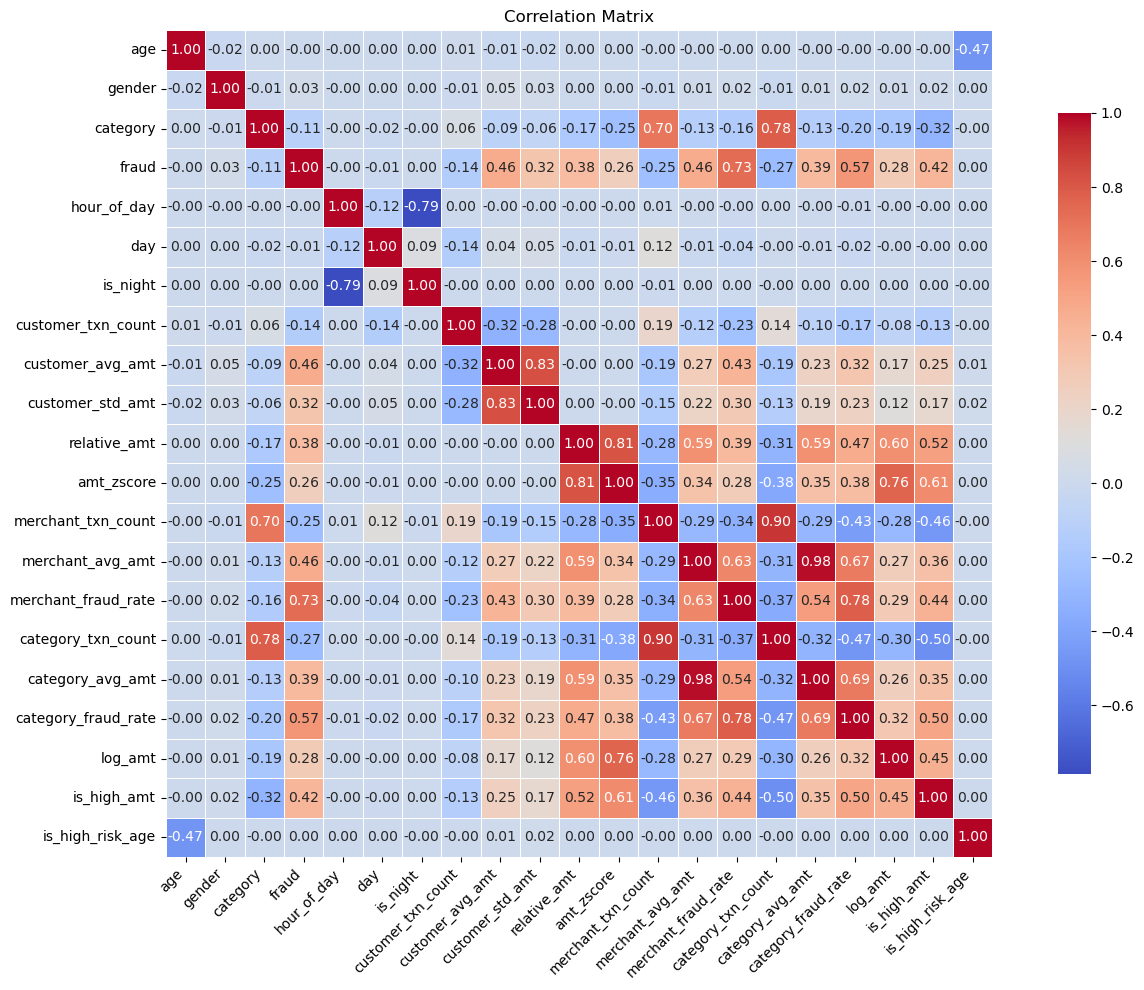

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix for numeric features only
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={'shrink': 0.8}, linewidths=0.5)
plt.title("Correlation Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [63]:
corr_with_target = df.corr(numeric_only=True)['fraud'].sort_values(key=abs, ascending=False)
print(corr_with_target)

fraud                  1.000000
merchant_fraud_rate    0.731215
category_fraud_rate    0.571078
customer_avg_amt       0.464966
merchant_avg_amt       0.463433
is_high_amt            0.415371
category_avg_amt       0.391471
relative_amt           0.384656
customer_std_amt       0.324238
log_amt                0.284242
category_txn_count    -0.267877
amt_zscore             0.259546
merchant_txn_count    -0.246864
customer_txn_count    -0.143394
category              -0.113529
gender                 0.025252
day                   -0.011875
age                   -0.003412
hour_of_day           -0.001914
is_night               0.001823
is_high_risk_age       0.001499
Name: fraud, dtype: float64


In [64]:
low_corr_features = [
    'gender',
    'day',
    'age',
    'hour_of_day',
    'is_night',
    'is_high_risk_age'
]
df = df.drop(columns=low_corr_features)

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 535178 entries, 425126 to 49743
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   category             535178 non-null  int64  
 1   fraud                535178 non-null  int64  
 2   customer_txn_count   535178 non-null  int64  
 3   customer_avg_amt     535178 non-null  float64
 4   customer_std_amt     535178 non-null  float64
 5   relative_amt         535178 non-null  float64
 6   amt_zscore           535178 non-null  float64
 7   merchant_txn_count   535178 non-null  int64  
 8   merchant_avg_amt     535178 non-null  float64
 9   merchant_fraud_rate  535178 non-null  float64
 10  category_txn_count   535178 non-null  int64  
 11  category_avg_amt     535178 non-null  float64
 12  category_fraud_rate  535178 non-null  float64
 13  log_amt              535178 non-null  float64
 14  is_high_amt          535178 non-null  int64  
dtypes: float64(9), int

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# === 1. Define features and target ===
X = df.drop(columns=['fraud'])  # All features
y = df['fraud']                 # Target

# === 2. Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === 3. Train Random Forest ===
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',   # helps with imbalanced data
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

# === 4. Predict ===
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]  # probability for fraud class (1)

# === 5. Evaluate ===
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n📈 ROC-AUC Score:")
print(roc_auc_score(y_test, y_proba))

🔍 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105738
           1       0.91      0.79      0.85      1298

    accuracy                           1.00    107036
   macro avg       0.95      0.90      0.92    107036
weighted avg       1.00      1.00      1.00    107036


📉 Confusion Matrix:
[[105638    100]
 [   269   1029]]

📈 ROC-AUC Score:
0.9922580395460115


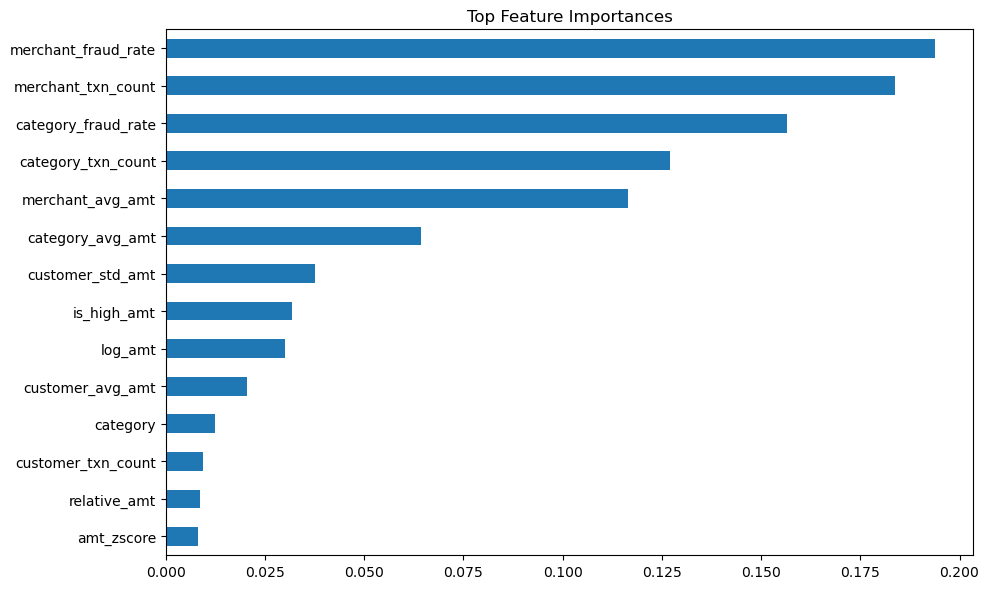

In [67]:
import matplotlib.pyplot as plt

importances = clf.feature_importances_
feat_names = X.columns

feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

# Plot top 15
plt.figure(figsize=(10, 6))
feat_imp[:15].plot(kind='barh')
plt.title("Top Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()